# Sentiment analysis using logistic regression

The **`sentiment`** data set consists of 3000 sentences which come from reviews on `imdb.com`, `amazon.com`, and `yelp.com`. Each sentence is labeled according to whether it comes from a positive review or negative review.

We will use <font color="magenta">logistic regression</font> to learn a classifier from this data.


## 1. Set up notebook, load and preprocess data

First, some standard includes.

In [1]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

Now, we load in the data. Make sure the notebook is the same directory as the folder `sentiment_labelled_sentences`, and that the folder contains `full_set.txt`.

The data set consists of 3000 sentences, each labeled '1' (if it came from a positive review) or '0' (if it came from a negative review). We change the negative review label to '-1'.

In [2]:
## Read in the data set.
with open("sentiment_labelled_sentences/full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

### Preprocessing the text data

To transform this prediction problem into one amenable to linear classification, we will first need to preprocess the text data. We will do four transformations:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors, using a bag-of-words representation.

We begin with first two steps.

In [3]:
## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

### Stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such 'to' and 'from'.

In [4]:
## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

What do the sentences look like so far?

In [5]:
sents_processed[0:10]

['so there is no way for me plug in here in us unless go by converter',
 'good case excellent value',
 'great for jawbone',
 'tied charger for conversations lasting more than minutes major problems',
 'mic is great',
 'have jiggle plug get line up right get decent volume',
 'if you have several dozen or several hundred contacts then imagine fun sending each them one by one',
 'if you are razr owner you must have this',
 'needless say wasted my money',
 'what waste money and time']

### Bag of words

In order to use linear classifiers on our data set, we need to transform our textual data into numeric data. The classical way to do this is known as the _bag of words_ representation. 

In this representation, each word is thought of as corresponding to a number in `{1, 2, ..., V}` where `V` is the size of our vocabulary. And each sentence is represented as a V-dimensional vector $x$, where $x_i$ is the number of times that word $i$ occurs in the sentence.

To do this transformation, we will make use of the `CountVectorizer` class in `scikit-learn`. We will cap the number of features at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in the corpus. This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.

Finally, we will also append a '1' to the end of each vector to allow our linear classifier to learn a bias term.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)

## Append '1' to the end of each vector.
data_mat = data_features.toarray()

### Training / test split

Finally, we split the data into a training set of 2500 sentences and a test set of 500 sentences (of which 250 are positive and 250 negative).

In [7]:
## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4500)
test data:  (500, 4500)


## 2. Fitting a logistic regression model to the training data

We implement logistic regression solver using stochastic gradient descent(SGD) from built into `scikit-learn`.

Due to the randomness in the SGD procedure, different runs can yield slightly different solutions (and thus different error values).

In [8]:
from sklearn.linear_model import SGDClassifier

## Fit logistic classifier on training data
clf = SGDClassifier(loss="log", penalty="none")
clf.fit(train_data, train_labels)

## Pull out the parameters (w,b) of the logistic regression model
w = clf.coef_[0,:]
b = clf.intercept_

## Get predictions on training and test data
preds_train = clf.predict(train_data)
preds_test = clf.predict(test_data)

## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))

print( "Training error: ", float(errs_train)/len(train_labels))
print( "Test error: ", float(errs_test)/len(test_labels))

/Users/Siddarth/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Training error:  0.016
Test error:  0.186


## 3. Analyzing the margin

The logistic regression model produces not just classifications but also conditional probability estimates. 

We will say that `x` has **margin** `gamma` if (according to the logistic regression model) `Pr(y=1|x) > (1/2)+gamma` or `Pr(y=1|x) < (1/2)-gamma`. The following function **margin_counts** takes as input the classifier (`clf`, computed earlier), the test set (`test_data`), and a value of `gamma`, and computes how many points in the test set have margin at least `gamma`.

In [9]:
## Return number of test points for which Pr(y=1) lies in [0, 0.5 - gamma) or (0.5 + gamma, 1]
def margin_counts(clf, test_data, gamma):
    ## Compute probability on each test point
    preds = clf.predict_proba(test_data)[:,1]
    ## Find data points for which prediction is at least gamma away from 0.5
    margin_inds = np.where((preds > (0.5+gamma)) | (preds < (0.5-gamma)))[0]
    
    return float(len(margin_inds))

We now visualize the test set's distribution of margin values.

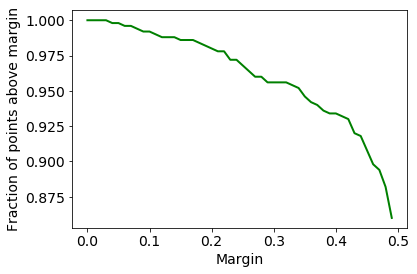

In [10]:
gammas = np.arange(0,0.5,0.01)
f = np.vectorize(lambda g: margin_counts(clf, test_data, g))
plt.plot(gammas, f(gammas)/500.0, linewidth=2, color='green')
plt.xlabel('Margin', fontsize=14)
plt.ylabel('Fraction of points above margin', fontsize=14)
plt.show()

Next, we investigate a natural question: <font color="magenta">Are points `x` with larger margin more likely to be classified correctly?</font>

To address this, we define a function **margin_errors** that computes the fraction of points with margin at least `gamma` that are misclassified.

In [11]:
## Return error of predictions that lie in intervals [0, 0.5 - gamma) and (0.5 + gamma, 1]
def margin_errors(clf, test_data, test_labels, gamma):
    ## Compute probability on each test point
    preds = clf.predict_proba(test_data)[:,1]
    
    ## Find data points for which prediction is at least gamma away from 0.5
    margin_inds = np.where((preds > (0.5+gamma)) | (preds < (0.5-gamma)))[0]
    
    ## Compute error on those data points.
    num_errors = np.sum((preds[margin_inds] > 0.5) != (test_labels[margin_inds] > 0.0))
    return float(num_errors)/len(margin_inds)

We now visualize the relationship between margin and error rate.

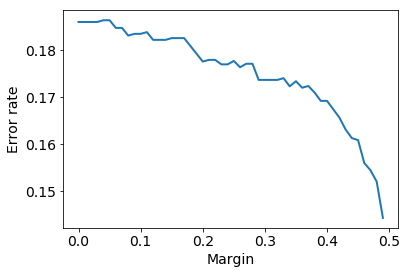

In [12]:
## Create grid of gamma values
gammas = np.arange(0, 0.5, 0.01)

## Compute margin_errors on test data for each value of g
f = np.vectorize(lambda g: margin_errors(clf, test_data, test_labels, g))

## Plot the result
plt.plot(gammas, f(gammas), linewidth=2)
plt.ylabel('Error rate', fontsize=14)
plt.xlabel('Margin', fontsize=14)
plt.show()

## 4. Words with large influence

Finally, we attempt to partially **interpret** the logistic regression model.

Which words are most important in deciding whether a sentence is positive? As a first approximation to this, we simply take the words whose coefficients in `w` have the largest positive values.

Likewise, we look at the words whose coefficients in `w` have the most negative values, and we think of these as influential in negative predictions.

In [13]:
## Convert vocabulary into a list:
vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])

## Get indices of sorting w
inds = np.argsort(w)

## Words with large negative values
neg_inds = inds[0:50]
print('\033[1m'+"Highly negative words: ")
print('\033[0m')
print([str(x) for x in list(vocab[neg_inds])])
print()
## Words with large positive values
pos_inds = inds[-49:-1]
print('\033[1m')
print("Highly positive words: ")
print('\033[0m')
print([str(x) for x in list(vocab[pos_inds])])

Highly negative words: 

['sucks', 'worst', 'bad', 'poor', 'avoid', 'aren', 'bland', 'wasn', 'pm', 'rude', 'started', 'unfortunately', 'directing', 'slow', 'mediocre', 'wasted', 'then', 'disappointment', 'minutes', 'ok', 'stereotypes', 'return', 'stupid', 'wife', 'fly', 'racial', 'literally', 'looks', 'waste', 'fails', 'another', 'ripped', 'low', 'picture', 'dishes', 'within', 'boring', 'make', 'torture', 'awful', 'guess', 'flat', 'green', 'sitting', 'not', 'disappointing', 'put', 'year', 'depth', 'received']


Highly positive words: 

['carry', 'happy', 'amount', 'sauce', 'art', 'tom', 'happier', 'brings', 'steak', 'best', 'wow', 'parts', 'enjoyed', 'cult', 'plays', 'beer', 'incredible', 'angel', 'definitely', 'ponyo', 'years', 'lovely', 'sex', 'family', 'hope', 'fun', 'occasionally', 'love', 'funny', 'decent', 'easy', 'cool', 'exactly', 'amazing', 'joy', 'scamp', 'works', 'awesome', 'delicious', 'great', 'loved', 'fantastic', 'liked', 'interesting', 'beautiful', 'comfortable', 'excel